### Setup

In [1]:
%pip install pandas xgboost scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

### Load data

In [3]:
customers = pd.read_csv('./data/customers.csv').sample(frac=0.10, random_state=42)
terminals = pd.read_csv('./data/terminals.csv').sample(frac=0.50, random_state=42)
merchants = pd.read_csv('./data/merchants.csv').sample(frac=0.15, random_state=42)
transactions_train = pd.read_csv('./data/transactions_train.csv').sample(frac=0.02, random_state=42)
transactions_test = pd.read_csv('./data/transactions_test.csv').sample(frac=0.05, random_state=42)

/tmp/ipykernel_1696/3021644446.py:4: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  transactions_train = pd.read_csv('./data/transactions_train.csv').sample(frac=0.02, random_state=42)  # 2% sample


### Info func

In [4]:
def print_info(df, name):
    print(f"--- {name} ---")
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print("Head:\n", df.head())
    print("\n")
print_info(customers, "Customers")
print_info(terminals, "Terminals")
print_info(merchants, "Merchants")
print_info(transactions_train, "Transactions Train")
print_info(transactions_test, "Transactions Test")

--- Customers ---
Shape: (5000, 3)
Columns: ['CUSTOMER_ID', 'x_customer_id', 'y_customer_id']
Head:
             CUSTOMER_ID  x_customer_id  y_customer_id
33553  8980116137813674      89.511405      42.901371
9427   7494991785718113      75.561490      70.121494
199    6293111408475835      31.060315       6.606118
12447  7963713036528187      72.345227       7.854360
39489  6873159655662680      38.234919       2.318740


--- Terminals ---
Shape: (2500, 3)
Columns: ['TERMINAL_ID', 'x_terminal_id', 'y_terminal__id']
Head:
       TERMINAL_ID  x_terminal_id  y_terminal__id
1501     37032636      18.219764       12.566445
2586     71430710      81.625375       60.972340
2653     85800218      20.713915       41.680638
1055     20182612      33.454415       90.685483
705      35672153      62.948620       58.625976


--- Merchants ---
Shape: (4568, 21)
Columns: ['MERCHANT_ID', 'BUSINESS_TYPE', 'MCC_CODE', 'LEGAL_NAME', 'FOUNDATION_DATE', 'TAX_EXCEMPT_INDICATOR', 'OUTLET_TYPE', 'ACTIVE_FROM

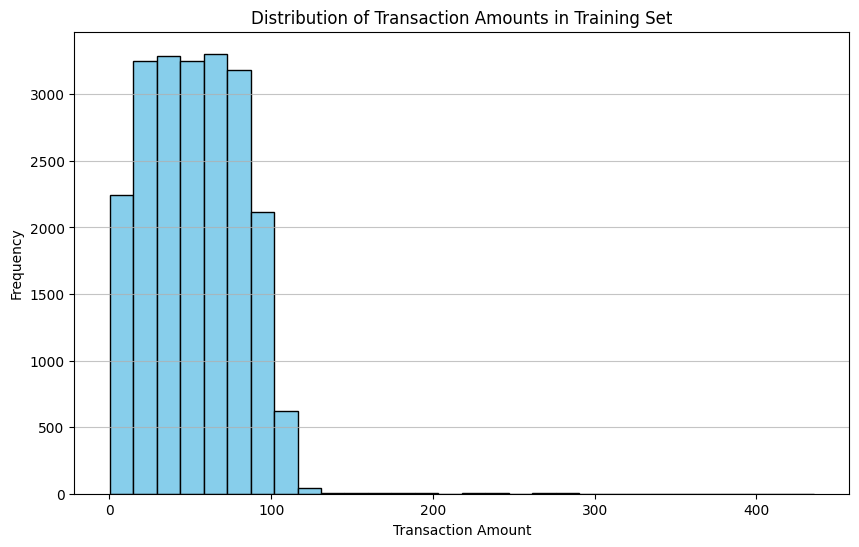

In [5]:
plt.figure(figsize=(10, 6))
plt.hist(transactions_train['TX_AMOUNT'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Transaction Amounts in Training Set')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

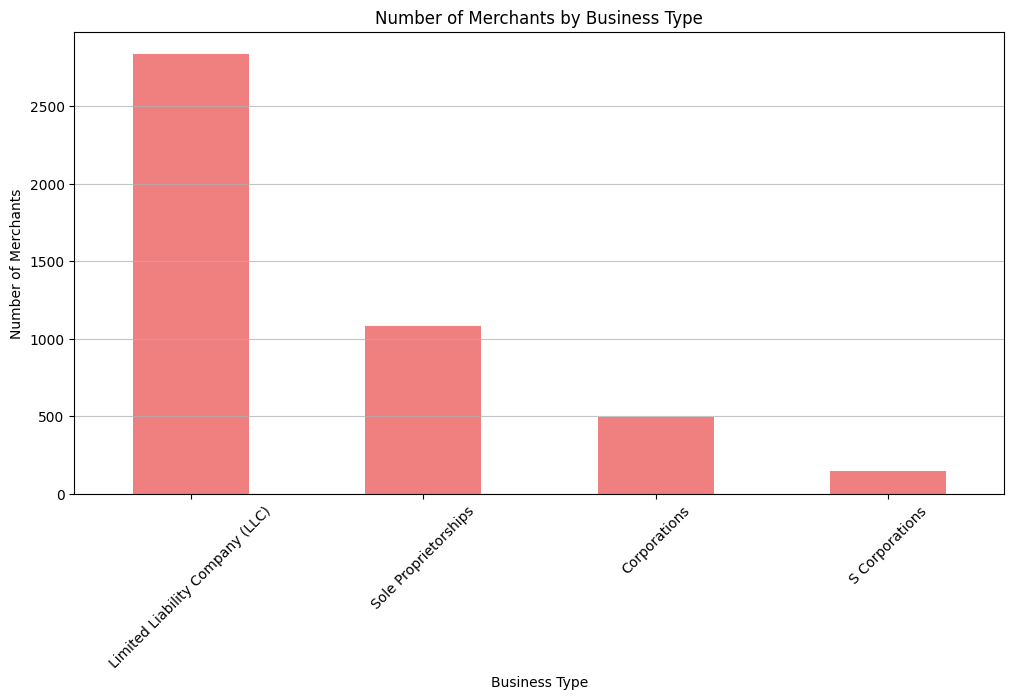

In [6]:
business_counts = merchants['BUSINESS_TYPE'].value_counts()
plt.figure(figsize=(12, 6))
business_counts.plot(kind='bar', color='lightcoral')
plt.title('Number of Merchants by Business Type')
plt.xlabel('Business Type')
plt.ylabel('Number of Merchants')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()

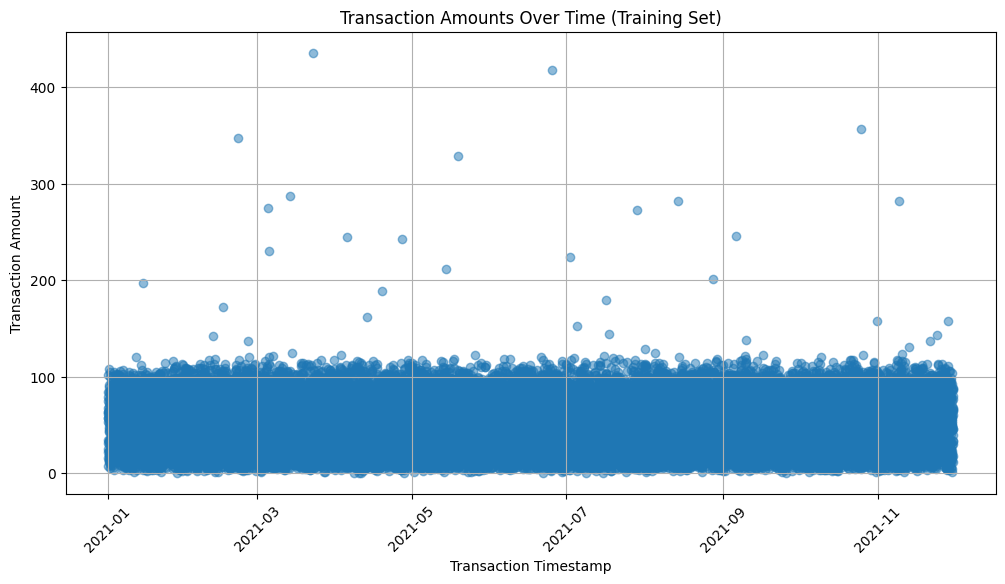

In [7]:
transactions_train['TX_TS'] = pd.to_datetime(transactions_train['TX_TS'], errors='coerce')
plt.figure(figsize=(12, 6))
plt.scatter(transactions_train['TX_TS'], transactions_train['TX_AMOUNT'], alpha=0.5)
plt.title('Transaction Amounts Over Time (Training Set)')
plt.xlabel('Transaction Timestamp')
plt.ylabel('Transaction Amount')
plt.xticks(rotation=45)
plt.grid()
plt.show()

<Figure size 1200x600 with 0 Axes>

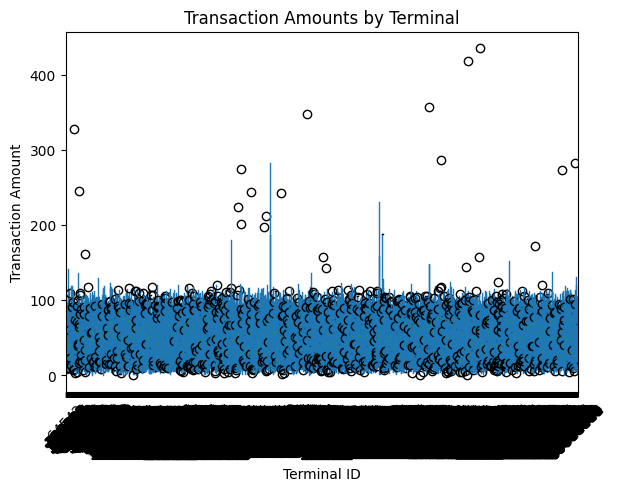

In [8]:
plt.figure(figsize=(12, 6))
transactions_train.boxplot(column='TX_AMOUNT', by='TERMINAL_ID', grid=False)
plt.title('Transaction Amounts by Terminal')
plt.suptitle('')
plt.xlabel('Terminal ID')
plt.ylabel('Transaction Amount')
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_1696/3786829266.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([transactions_train[transactions_train['TX_FRAUD'] == 0]['TX_AMOUNT'],


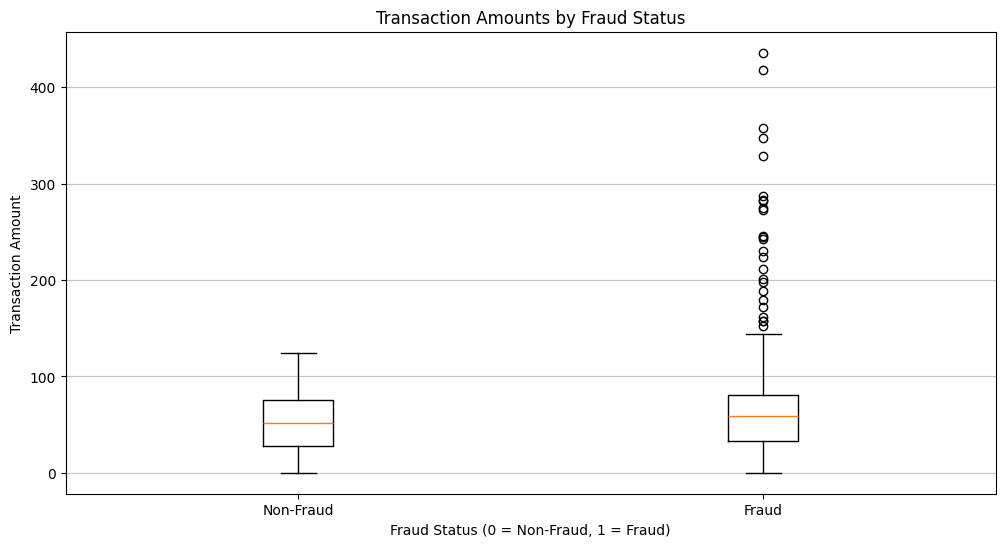

In [9]:
plt.figure(figsize=(12, 6))
plt.boxplot([transactions_train[transactions_train['TX_FRAUD'] == 0]['TX_AMOUNT'],
             transactions_train[transactions_train['TX_FRAUD'] == 1]['TX_AMOUNT']],
            labels=['Non-Fraud', 'Fraud'])
plt.title('Transaction Amounts by Fraud Status')
plt.xlabel('Fraud Status (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Transaction Amount')
plt.grid(axis='y', alpha=0.75)
plt.show()

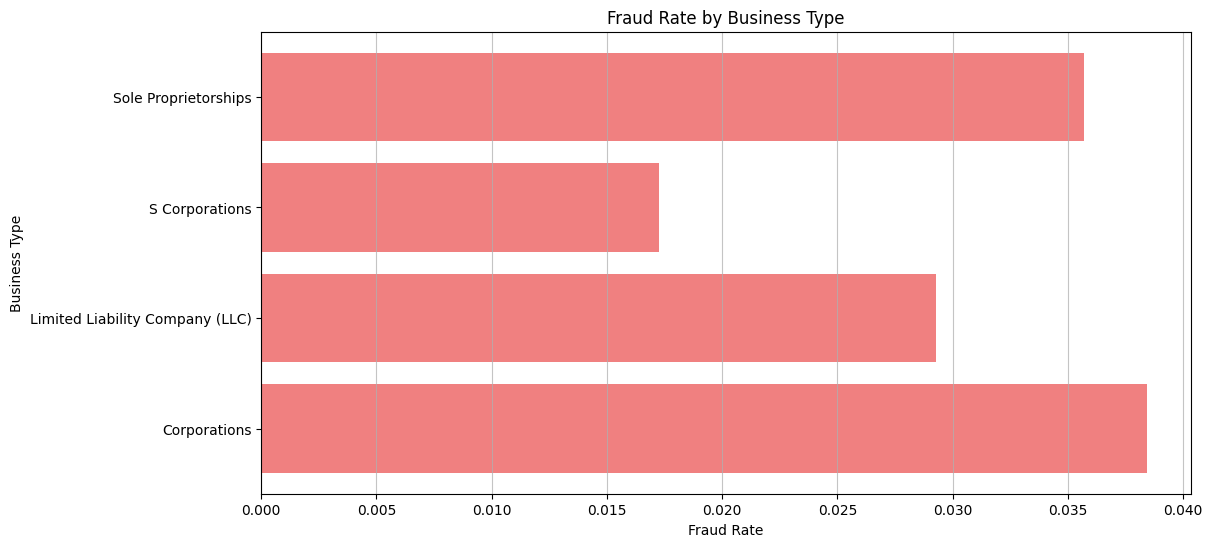

In [10]:
fraud_rate_by_business = transactions_train.groupby('MERCHANT_ID')['TX_FRAUD'].mean().reset_index()
fraud_rate_by_business = fraud_rate_by_business.merge(merchants[['MERCHANT_ID', 'BUSINESS_TYPE']], on='MERCHANT_ID')
fraud_rate_by_business = fraud_rate_by_business.groupby('BUSINESS_TYPE')['TX_FRAUD'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.barh(fraud_rate_by_business['BUSINESS_TYPE'], fraud_rate_by_business['TX_FRAUD'], color='lightcoral')
plt.title('Fraud Rate by Business Type')
plt.xlabel('Fraud Rate')
plt.ylabel('Business Type')
plt.grid(axis='x', alpha=0.75)
plt.show()

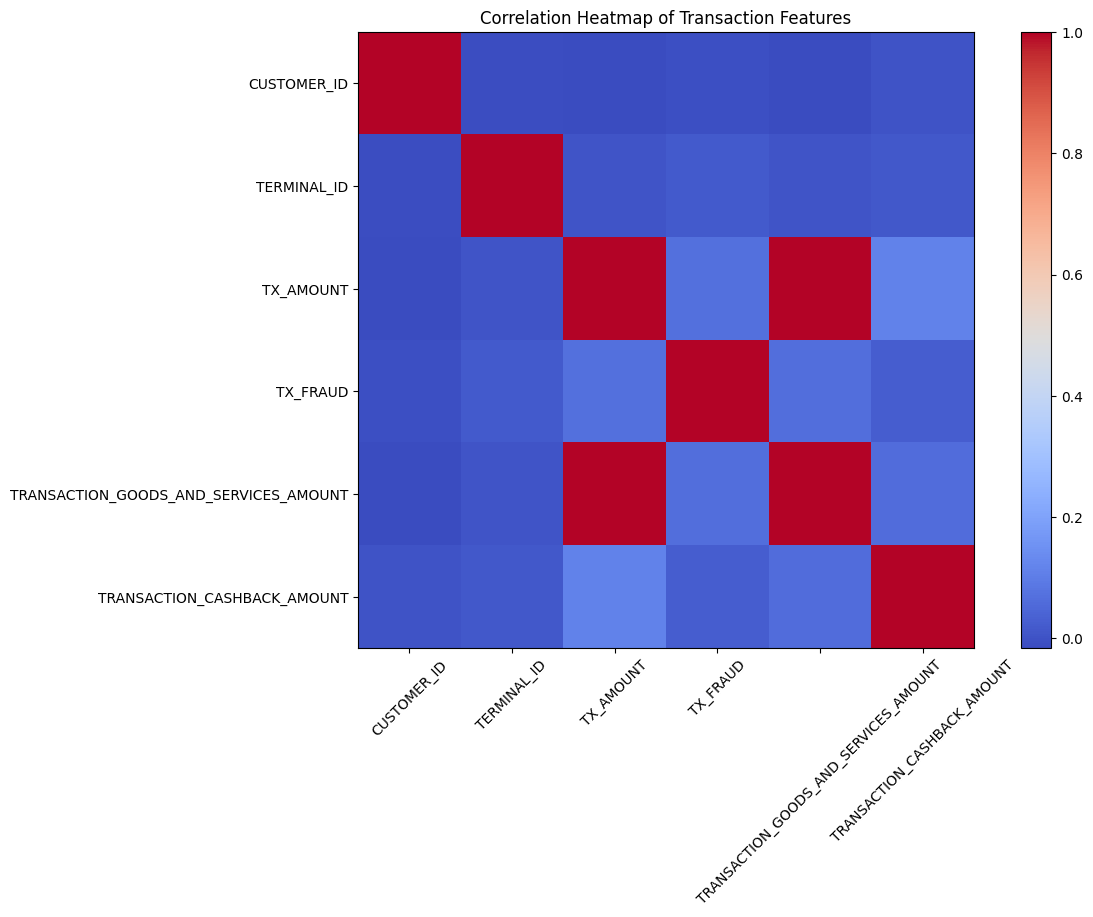

In [11]:
numeric_columns = transactions_train.select_dtypes(include=['number']).columns
correlation_matrix = transactions_train[numeric_columns].corr()

plt.figure(figsize=(12, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Correlation Heatmap of Transaction Features')
plt.show()

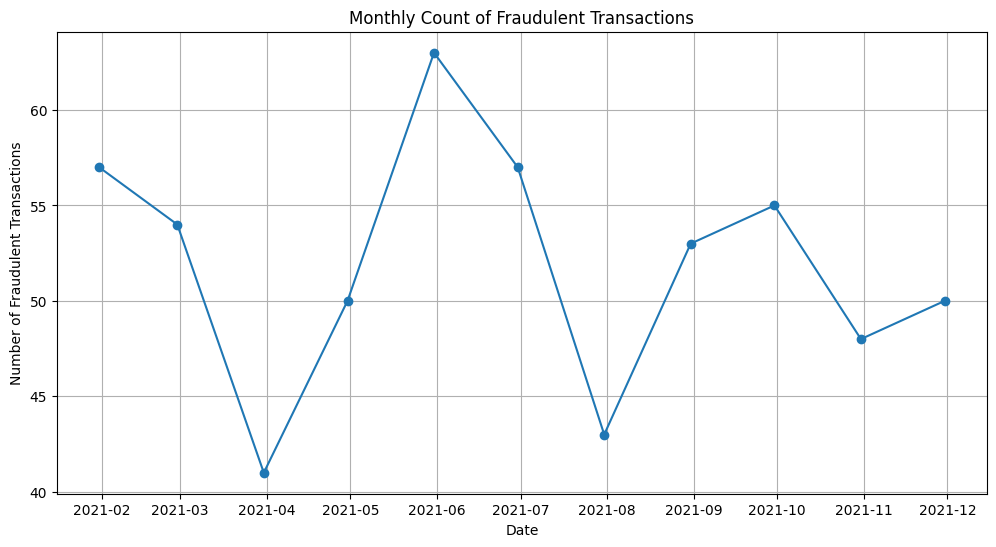

In [12]:
transactions_train['TX_TS'] = pd.to_datetime(transactions_train['TX_TS'])
monthly_fraud_counts = transactions_train.resample('ME', on='TX_TS')['TX_FRAUD'].sum()

plt.figure(figsize=(12, 6))
plt.plot(monthly_fraud_counts.index, monthly_fraud_counts.values, marker='o', linestyle='-')
plt.title('Monthly Count of Fraudulent Transactions')
plt.xlabel('Date')
plt.ylabel('Number of Fraudulent Transactions')
plt.grid()
plt.show()

### Merge dataframes

In [13]:
data = transactions_train.merge(customers, on='CUSTOMER_ID', how='left')
data = data.merge(terminals, on='TERMINAL_ID', how='left')
data = data.merge(merchants, on='MERCHANT_ID', how='left')

## Features

In [14]:
features = ['TX_AMOUNT', 'TRANSACTION_GOODS_AND_SERVICES_AMOUNT', 'TRANSACTION_CASHBACK_AMOUNT',
            'CARD_BRAND', 'TRANSACTION_TYPE', 'TRANSACTION_STATUS', 'TRANSACTION_CURRENCY',
            'CARD_COUNTRY_CODE', 'IS_RECURRING_TRANSACTION', 'CARDHOLDER_AUTH_METHOD',
            'BUSINESS_TYPE', 'MCC_CODE', 'OUTLET_TYPE', 'ANNUAL_TURNOVER_CARD', 'ANNUAL_TURNOVER',
            'AVERAGE_TICKET_SALE_AMOUNT', 'PAYMENT_PERCENTAGE_FACE_TO_FACE', 'PAYMENT_PERCENTAGE_ECOM',
            'PAYMENT_PERCENTAGE_MOTO', 'DEPOSIT_REQUIRED_PERCENTAGE', 'DEPOSIT_PERCENTAGE',
            'DELIVERY_SAME_DAYS_PERCENTAGE', 'DELIVERY_WEEK_ONE_PERCENTAGE', 'DELIVERY_WEEK_TWO_PERCENTAGE',
            'DELIVERY_OVER_TWO_WEEKS_PERCENTAGE']

### Prepare data

In [15]:
X = data[features].copy()
y = data['TX_FRAUD']

### Handle categorical variables

In [16]:
le = LabelEncoder()
for column in X.select_dtypes(include=['object']).columns:
    X.loc[:, column] = le.fit_transform(X[column].astype(str))

### Split data

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train model

In [18]:
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

### Predictions

In [19]:
y_pred = model.predict(X_test)

### Evaluate the model

In [20]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

Mean Squared Error: 0.05039849976558837
R2 Score: -1.0610409134115186


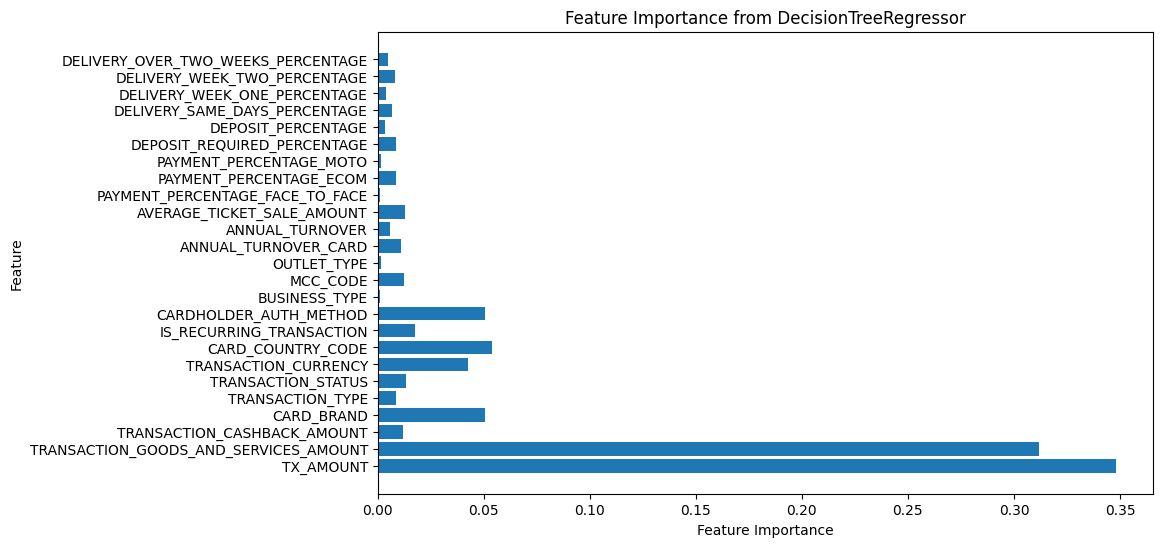

In [21]:
importance = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X.columns, importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from DecisionTreeRegressor')
plt.show()

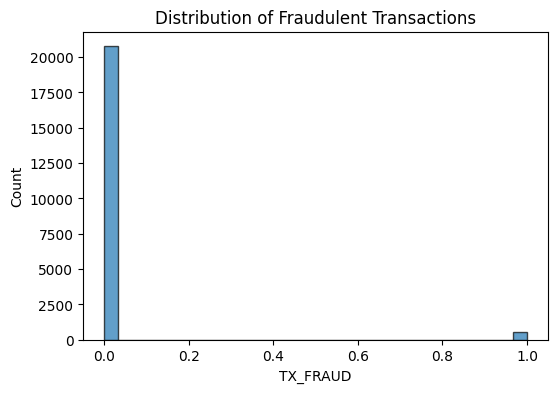

In [22]:
plt.figure(figsize=(6, 4))
plt.hist(y, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Fraudulent Transactions')
plt.xlabel('TX_FRAUD')
plt.ylabel('Count')
plt.show()

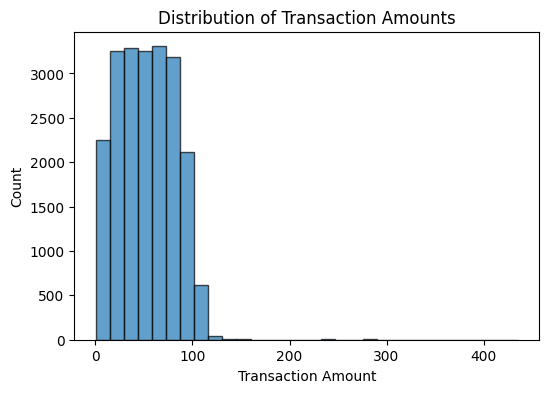

In [23]:
plt.figure(figsize=(6, 4))
plt.hist(data['TX_AMOUNT'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.show()

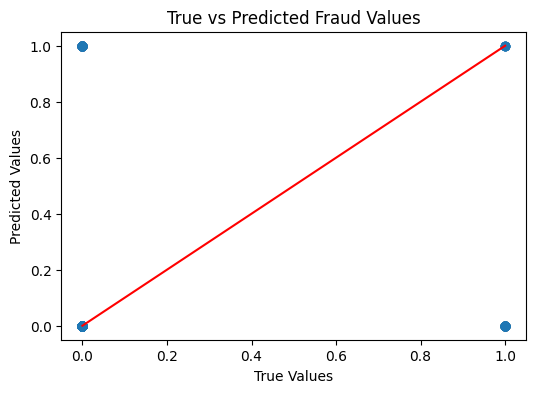

In [24]:
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.title('True vs Predicted Fraud Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.show()